In [1]:
import seaborn as sns

In [2]:
df = sns.load_dataset('titanic')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df1 = df.loc[:,'survived,pclass,sex,age,embarked,alone,fare'.split(',')].replace({'alone':{True:1,False:0}}).copy()
X = df1.drop(columns=['survived'])
y = df1['survived']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7716\46218132.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1 = df.loc[:,'survived,pclass,sex,age,embarked,alone,fare'.split(',')].replace({'alone':{True:1,False:0}}).copy()


In [5]:
from feature_engine import encoding, imputation, scaling
from sklearn import pipeline, model_selection, preprocessing

In [6]:
titanic_pipeline=pipeline.Pipeline(
    [
    ('cat_impute',imputation.CategoricalImputer(imputation_method='frequent',variables=['embarked'])),
    ('cat',encoding.OneHotEncoder(variables=['sex','embarked'])),
    ('num_impute',imputation.MeanMedianImputer(imputation_method='median',variables=['age'])),
    ('scale',scaling.MeanNormalizationScaler(variables=['fare']))
    ]
)

In [7]:
X_train,X_test, y_train,y_test = model_selection.train_test_split(X,y,test_size=.2,random_state=42,stratify=y)

In [8]:
X_train = titanic_pipeline.fit_transform(X_train, y_train)

In [9]:
X_train.head()

,pclass,age,alone,fare,sex_male,sex_female,embarked_S,embarked_C,embarked_Q
692,3,28.5,1,0.048164,1,0,1,0,0
481,2,28.5,1,-0.062108,1,0,1,0,0
527,1,28.5,1,0.370776,1,0,1,0,0
855,3,18.0,0,-0.043858,0,1,1,0,0
801,2,31.0,0,-0.010872,0,1,1,0,0


In [10]:
import pandas as pd

(
X_train
.assign(survived=y_train==1)
.corr(method='spearman')
.style
.background_gradient(cmap='RdBu',vmax=1, vmin=-1)

)

,pclass,age,alone,fare,sex_male,sex_female,embarked_S,embarked_C,embarked_Q,survived
pclass,1.000000,-0.308272,0.130877,-0.675508,0.144753,-0.144753,0.084777,-0.245589,0.223234,-0.345598
age,-0.308272,1.000000,0.148978,0.113000,0.052954,-0.052954,-0.019129,0.028825,-0.010895,-0.030962
alone,0.130877,0.148978,1.000000,-0.520667,0.320104,-0.320104,0.040432,-0.092443,0.069818,-0.215570
fare,-0.675508,0.113000,-0.520667,1.000000,-0.274454,0.274454,-0.085582,0.228681,-0.196788,0.342385
sex_male,0.144753,0.052954,0.320104,-0.274454,1.000000,-1.000000,0.138836,-0.100746,-0.081956,-0.549171
sex_female,-0.144753,-0.052954,-0.320104,0.274454,-1.000000,1.000000,-0.138836,0.100746,0.081956,0.549171
embarked_S,0.084777,-0.019129,0.040432,-0.085582,0.138836,-0.138836,1.000000,-0.804811,-0.472784,-0.179163
embarked_C,-0.245589,0.028825,-0.092443,0.228681,-0.100746,0.100746,-0.804811,1.000000,-0.142505,0.180029
embarked_Q,0.223234,-0.010895,0.069818,-0.196788,-0.081956,0.081956,-0.472784,-0.142505,1.000000,0.031501
survived,-0.345598,-0.030962,-0.215570,0.342385,-0.549171,0.549171,-0.179163,0.180029,0.031501,1.000000


In [11]:
from yellowbrick import target

### Check distribution of labels 

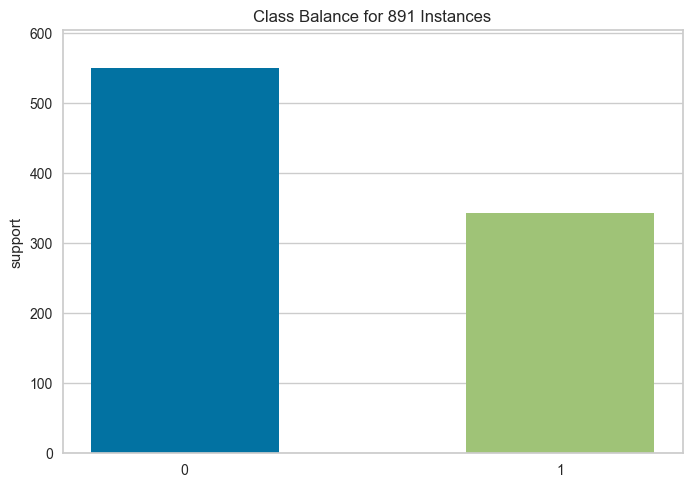

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 891 Instances'}, ylabel='support'>)

In [12]:
target.class_balance(df1['survived'])

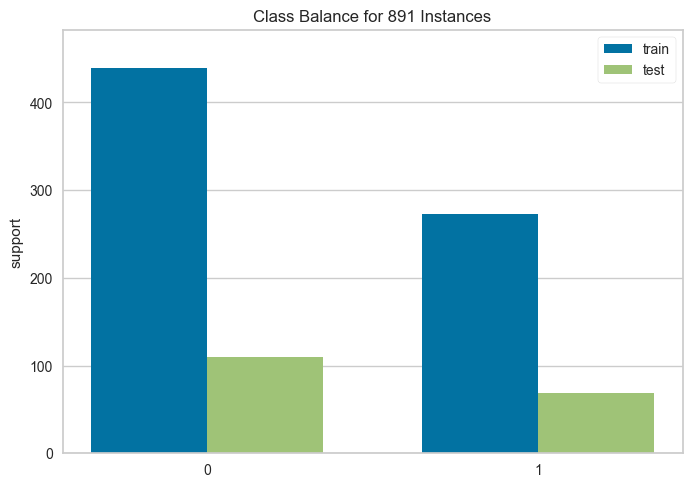

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 891 Instances'}, ylabel='support'>)

In [13]:
target.class_balance(y_train=y_train,y_test=y_test)

### Run baseline model

In [14]:
import xgboost as xgb

dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical = True)

In [15]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix,roc_auc_score

params_1 = {"objective": "binary:logistic"}

n = 1000

results = xgb.cv(params_1,
                 dtrain_clf,
                 num_boost_round = n,
                 nfold=5,
                 metrics = ["logloss","auc","error"],
                 early_stopping_rounds=20
                 )

In [16]:
results

,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.531847,0.002817,0.900628,0.011088,0.185391,0.007780,0.551754,0.007919,0.858257,0.022008,0.200857,0.010767
1,0.457506,0.004044,0.915238,0.007261,0.140446,0.008891,0.495038,0.012535,0.857234,0.030363,0.179789,0.009772
2,0.410052,0.005289,0.922389,0.004973,0.127459,0.006361,0.460837,0.012797,0.863290,0.027316,0.175584,0.017420
